## Programming exercises

### 6.1 Decision tree pruning using cross-validation

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn import tree

In [50]:
# Load Matlab data file and extract variables of interest
mat_data = loadmat('wine2.mat')
X = np.matrix(mat_data['X'])
y = np.matrix(mat_data['y'], dtype=int)
attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
classNames = [name[0][0] for name in mat_data['classNames']]
N, M = X.shape
C = len(classNames)


In [51]:
df=pd.DataFrame(X).set_axis(attributeNames,axis=1,inplace=False)
df["y"]=y
df.head()

,Fixed acidity,Volatile acidity,Citric acid,Residual sugar,Chlorides,Free sulfur dioxide,Total sulfur dioxide,Density,pH,Sulphates,Alcohol,y
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


`max_depth`:
This indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data. We fit a decision tree with depths ranging from 2 to 20 and plot the training and test auc scores.

In [52]:
# exercise 6.1.1
# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 21, 1)

# Simple holdout-set crossvalidation
test_proportion = 0.5

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=test_proportion,random_state=1)

# Initialize variables
Error_train = []
Error_test = []

for t in tc:
    # Fit decision tree classifier, Gini split criterion, different pruning levels
    dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=t)
    dtc = dtc.fit(X_train,y_train)
    pred_train=dtc.predict(X_train)
    pred_test= dtc.predict(X_test)
    err_train,err_test=0,0    
    for a,b in zip(np.array(y_train).flatten(),pred_train):
        if a!=b:
            err_train+=1
    Error_train.append(err_train/len(pred_train))
    for a,b in zip(np.array(y_test).flatten(),pred_test):
        if a!=b:
            err_test+=1
    Error_test.append(err_test/len(pred_test))  


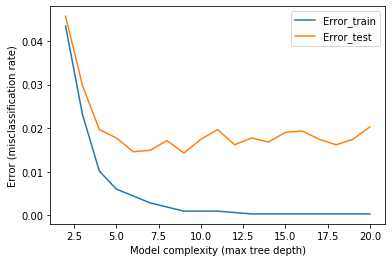

In [53]:
plt.plot(tc, Error_train)
plt.plot(tc, Error_test)
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Error (misclassification rate)')
plt.legend(['Error_train','Error_test']);
            

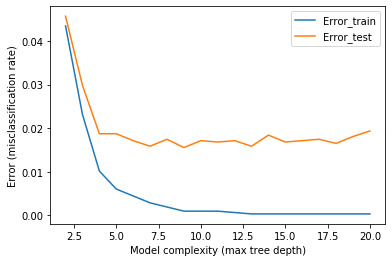

In [54]:
# Initialize variables
Error_train = np.empty((len(tc),1))
Error_test = np.empty((len(tc),1))

for i, t in enumerate(tc):
    # Fit decision tree classifier, Gini split criterion, different pruning levels
    dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=t)
    dtc = dtc.fit(X_train,y_train.ravel().T)

    # Evaluate classifier's misclassification rate over train/test data
    y_est_test = dtc.predict(X_test)
    y_est_train = dtc.predict(X_train)
    misclass_rate_test = sum(np.abs(np.mat(y_est_test).T - y_test)) / float(len(y_est_test))
    misclass_rate_train = sum(np.abs(np.mat(y_est_train).T - y_train)) / float(len(y_est_train))
    Error_test[i], Error_train[i] = misclass_rate_test, misclass_rate_train
    
f = plt.figure();
plt.plot(tc, Error_train)
plt.plot(tc, Error_test)
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Error (misclassification rate)')
plt.legend(['Error_train','Error_test'])
    
plt.show() 

### Using 10-fold cross-validation 

In [55]:
from sklearn.model_selection import KFold, cross_val_score

In [9]:
###### Method 1 #######

In [56]:
# exercise 6.1.2
seed = 7
K=10
CV = KFold(n_splits=K, random_state=seed)
# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 21, 1)
Error_test=[]
Error_mean=[]
for t in tc:
    dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=t)
    accuracy = cross_val_score(dtc, X, y, cv=CV)
    Errors=1-accuracy
    Error_test.append(Errors)
    Error_mean.append(Errors.mean())

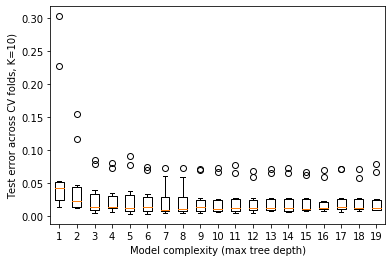

In [57]:
plt.boxplot(Error_test)
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Test error across CV folds, K={0})'.format(K));

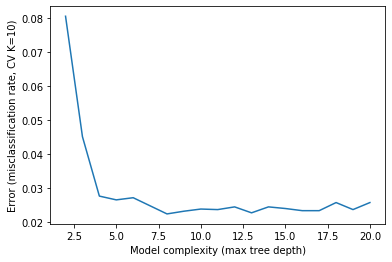

In [58]:
plt.plot(tc, Error_mean)
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Error (misclassification rate, CV K={0})'.format(K));


In [ ]:
###### Method 2 #######

In [59]:
# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 21, 1)

# K-fold crossvalidation
K = 10
CV = KFold(n_splits=K,random_state=seed)

# Initialize variable
Error_train = np.empty((len(tc),K))
Error_test = np.empty((len(tc),K))

k=0
for train_index, test_index in CV.split(X):
    print('Computing CV fold: {0}/{1}..'.format(k+1,K))

    # extract training and test set for current CV fold
    X_train, y_train = X[train_index,:].A, y[train_index,:].A
    X_test, y_test = X[test_index,:].A, y[test_index,:].A

    for i, t in enumerate(tc):
        # Fit decision tree classifier, Gini split criterion, different pruning levels
        dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=t)
        dtc = dtc.fit(X_train,y_train.ravel())
        y_est_test = dtc.predict(X_test)
        y_est_train = dtc.predict(X_train)
        # Evaluate misclassification rate over train/test data (in this CV fold)
        misclass_rate_test = sum(np.abs(np.mat(y_est_test).T - y_test)) / float(len(y_est_test))
        misclass_rate_train = sum(np.abs(np.mat(y_est_train).T - y_train)) / float(len(y_est_train))
        Error_test[i,k], Error_train[i,k] = misclass_rate_test, misclass_rate_train
    k+=1

Computing CV fold: 1/10..
Computing CV fold: 2/10..
Computing CV fold: 3/10..
Computing CV fold: 4/10..
Computing CV fold: 5/10..
Computing CV fold: 6/10..
Computing CV fold: 7/10..
Computing CV fold: 8/10..
Computing CV fold: 9/10..
Computing CV fold: 10/10..


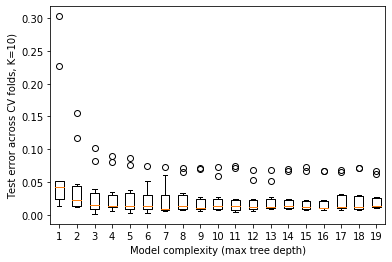

In [15]:
plt.boxplot(Error_test.T)
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Test error across CV folds, K={0})'.format(K));

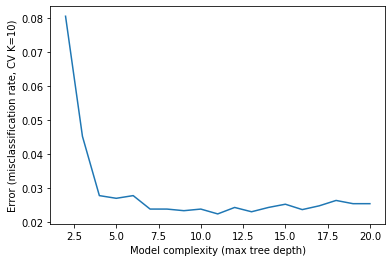

In [14]:
plt.plot(tc, Error_mean)
plt.xlabel('Model complexity (max tree depth)')
plt.ylabel('Error (misclassification rate, CV K={0})'.format(K));

### 6.2 Variable selection in linear regression

In [60]:
#Import Linear Regression model from scikit-learn.
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [61]:
# Load data from matlab file
mat_data = loadmat('body.mat')
X = np.matrix(mat_data['X'])
y = np.matrix(mat_data['y'])
attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
N, M = X.shape

df=pd.DataFrame(X).set_axis(attributeNames ,axis=1,inplace=False)
df.head(9)


,biacromial,pelvic.breadth,bitrochanteric,chest.depth,chest.diam,elbow.diam,wrist.diam,knee.diam,ankle.diam,shoulder.girth,...,hip.girth,thigh.girth,bicep.girth,forearm.girth,knee.girth,calf.girth,ankle.girth,wrist.girth,age,height
0,42.9,26.0,31.5,17.7,28.0,13.1,10.4,18.8,14.1,106.2,...,93.5,51.5,32.5,26.0,34.5,36.5,23.5,16.5,21.0,174.0
1,43.7,28.5,33.5,16.9,30.8,14.0,11.8,20.6,15.1,110.5,...,94.8,51.5,34.4,28.0,36.5,37.5,24.5,17.0,23.0,175.3
2,40.1,28.2,33.3,20.9,31.7,13.9,10.9,19.7,14.1,115.1,...,95.0,57.3,33.4,28.8,37.0,37.3,21.9,16.9,28.0,193.5
3,44.3,29.9,34.0,18.4,28.2,13.9,11.2,20.9,15.0,104.5,...,94.0,53.0,31.0,26.2,37.0,34.8,23.0,16.6,23.0,186.5
4,42.5,29.9,34.0,21.5,29.4,15.2,11.6,20.7,14.9,107.5,...,98.5,55.4,32.0,28.4,37.7,38.6,24.4,18.0,22.0,187.2
5,43.3,27.0,31.5,19.6,31.3,14.0,11.5,18.8,13.9,119.8,...,95.3,57.5,33.0,28.0,36.6,36.1,23.5,16.9,20.6,181.5
6,43.5,30.0,34.0,21.9,31.7,16.1,12.5,20.8,15.6,123.5,...,101.0,60.9,42.4,32.3,40.1,40.3,23.6,18.8,25.5,184.0
7,44.4,29.8,33.2,21.8,28.8,15.1,11.9,21.0,14.6,120.4,...,98.0,56.0,34.1,28.0,39.2,36.7,22.5,18.0,26.9,184.5
8,43.5,26.5,32.1,15.5,27.5,14.1,11.2,18.9,13.2,111.0,...,89.5,50.0,33.0,26.0,35.5,35.0,22.0,16.5,22.8,175.0


**Function 1:** validating linear regression model using 'cvf'-fold cross validation

In [62]:
def glm_validate(X,y,cvf=10):
    ''' Validate linear regression model using 'cvf'-fold cross validation.
        The loss function computed as mean squared error on validation set (MSE).
        Function returns MSE averaged over 'cvf' folds.

        Parameters:
        X       training data set
        y       vector of values
        cvf     number of crossvalidation folds        
    '''
    from sklearn import model_selection, linear_model
    CV = model_selection.KFold(cvf)
    validation_error=np.empty(cvf)
    f=0
    for train_index, test_index in CV.split(X):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        m = linear_model.LinearRegression().fit(X_train, y_train)
        validation_error[f] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]
        f=f+1
    return validation_error.mean()

**Function 2:** performing feature selection for linear regression model using'cvf'-fold cross validation

In [63]:
def feature_selector_lr(X,y,cvf=10,features_record=None,loss_record=None):
    ''' Function performs feature selection for linear regression model using
        'cvf'-fold cross validation. The process starts with empty set of
        features, and in every recurrent step one feature is added to the set
        (the feature that minimized loss function in cross-validation.)

        Parameters:
        X       training data set
        y       vector of values
        cvf     number of crossvalidation folds

        Returns:
        selected_features   indices of optimal set of features
        features_record     boolean matrix where columns correspond to features
                            selected in subsequent steps
        loss_record         vector with cv errors in subsequent steps
        
        Example:
        selected_features, features_record, loss_record = ...
            feature_selector_lr(X_train, y_train, cvf=10)
            
    ''' 

    # first iteration error corresponds to no-feature estimator
    if np.all(loss_record==None):
        loss_record = np.array([np.square(y-y.mean()).sum()/y.shape[0]])
    if np.all(features_record==None):
        features_record = np.zeros((X.shape[1],1))

    # Add one feature at a time to find the most significant one.
    # Include only features not added before.
    selected_features = features_record[:,-1].nonzero()[0]
    min_loss = loss_record[-1]
    #print(min_loss)
    best_feature = False
    for feature in range(0,X.shape[1]):
        if np.where(selected_features==feature)[0].size==0:
            trial_selected = np.concatenate((selected_features,np.array([feature])),0).astype(int)
            # validate selected features with linear regression and cross-validation:
            trial_loss = glm_validate(X[:,trial_selected],y,cvf)
            #print(trial_loss)
            if trial_loss<min_loss:
                min_loss = trial_loss 
                best_feature = feature

    # If adding extra feature decreased the loss function, update records
    # and go to the next recursive step
    if best_feature!=False:
        features_record = np.concatenate((features_record, np.array([features_record[:,-1]]).T), 1)
        features_record[best_feature,-1]=1
        loss_record = np.concatenate((loss_record,np.array([min_loss])),0)
        selected_features, features_record, loss_record = feature_selector_lr(X,y,cvf,features_record,loss_record)
        
    # Return current records and terminate procedure
    return selected_features, features_record, loss_record

**Function 3:** ploting matrix X as image with lines separating fields

In [64]:
def bmplot(yt, xt, X):
    ''' Function plots matrix X as image with lines separating fields. '''
    plt.imshow(X,interpolation='none',cmap='bone')
    plt.xticks(range(0,len(xt)), xt)
    plt.yticks(range(0,len(yt)), yt)
    for i in range(0,len(yt)):
        plt.axhline(i-0.5, color='black')
    for i in range(0,len(xt)):
        plt.axvline(i-0.5, color='black')

Cross validation fold 1/5
Train indices: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Test indices: [0 1 2 3 4 5]
Features no: 10



C:\Users\Meghdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Meghdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Cross validation fold 2/5
Train indices: [ 0  1  2  3  4  5 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29]
Test indices: [ 6  7  8  9 10 11]
Features no: 9



C:\Users\Meghdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Meghdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Cross validation fold 3/5
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 18 19 20 21 22 23 24 25 26 27 28 29]
Test indices: [12 13 14 15 16 17]
Features no: 7



C:\Users\Meghdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Meghdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Cross validation fold 4/5
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 24 25 26 27 28 29]
Test indices: [18 19 20 21 22 23]
Features no: 8



C:\Users\Meghdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Meghdad\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Cross validation fold 5/5
Train indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Test indices: [24 25 26 27 28 29]
Features no: 6



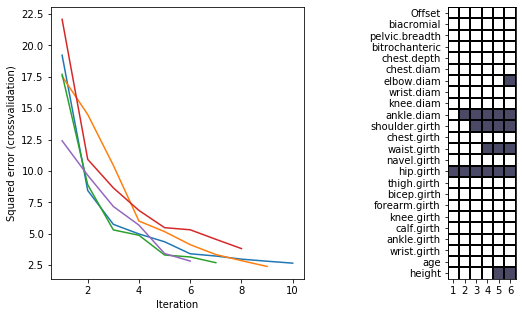

In [65]:
# exercise 6.2.1

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attributeNames = [u'Offset']+attributeNames
M = M+1

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 5
CV = KFold(n_splits=K,random_state=seed)

# Initialize variables
Features = np.zeros((M,K))
Error_train = np.empty((K,1))
Error_test = np.empty((K,1))
Error_train_fs = np.empty((K,1))
Error_test_fs = np.empty((K,1))
Error_train_nofeatures = np.empty((K,1))
Error_test_nofeatures = np.empty((K,1))

plt.figure(figsize=(10,5))
k=0
for train_index, test_index in CV.split(X):    
    # extract training and test set for current CV fold
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]  
    
    internal_cross_validation = 10
    
    # Compute squared error without using the input data at all
    Error_train_nofeatures[k] = np.square(y_train-y_train.mean()).sum()/y_train.shape[0]
    Error_test_nofeatures[k] = np.square(y_test-y_test.mean()).sum()/y_test.shape[0]

    # Compute squared error with all features selected (no feature selection)
    m = LinearRegression().fit(X_train, y_train)
    Error_train[k] = np.square(y_train-m.predict(X_train)).sum()/y_train.shape[0]
    Error_test[k] = np.square(y_test-m.predict(X_test)).sum()/y_test.shape[0]

    # Compute squared error with feature subset selection
    selected_features, features_record, loss_record = feature_selector_lr(X_train, y_train, internal_cross_validation)
    Features[selected_features,k]=1
    # .. alternatively you could use module sklearn.feature_selection
    m = LinearRegression().fit(X_train[:,selected_features], y_train)
    Error_train_fs[k] = np.square(y_train-m.predict(X_train[:,selected_features])).sum()/y_train.shape[0]
    Error_test_fs[k] = np.square(y_test-m.predict(X_test[:,selected_features])).sum()/y_test.shape[0]

    #    
    plt.subplot(1,2,1)
    plt.plot(range(1,len(loss_record)), loss_record[1:])
    plt.xlabel('Iteration')
    plt.ylabel('Squared error (crossvalidation)')    
    
    plt.subplot(1,2,2)
    bmplot(attributeNames, range(1,features_record.shape[1]), -features_record[:,1:])
    plt.clim(-1.5,0)
    #plt.xlabel('Iteration')

    print('Cross validation fold {0}/{1}'.format(k+1,K))
    print('Train indices: {0}'.format(train_index))
    print('Test indices: {0}'.format(test_index))
    print('Features no: {0}\n'.format(selected_features.size))

    k+=1



Linear regression without feature selection:

- Training error: 2.554478865141277e-26
- Test error:     1079.9022820163284
- R^2 train:     1.0
- R^2 test:     -15.360296663505334
Linear regression with feature selection:

- Training error: 1.4367971286615195
- Test error:     11.186348579812872
- R^2 train:     0.9794122387020878
- R^2 test:     0.8305291280564652


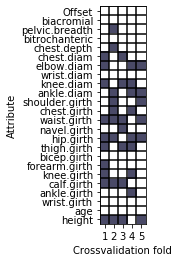

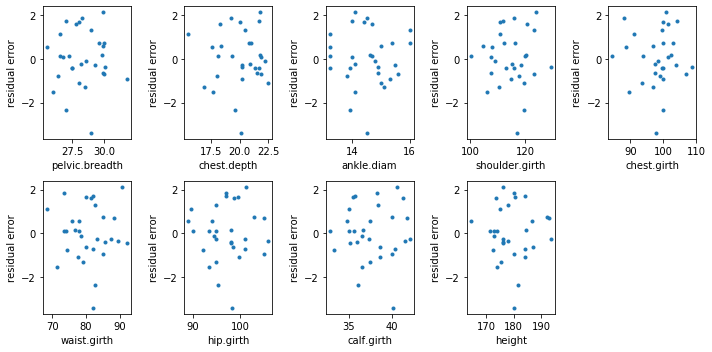

In [70]:
# Display results
print('\n')
print('Linear regression without feature selection:\n')
print('- Training error: {0}'.format(Error_train.mean()))
print('- Test error:     {0}'.format(Error_test.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test.sum())/Error_test_nofeatures.sum()))
print('Linear regression with feature selection:\n')
print('- Training error: {0}'.format(Error_train_fs.mean()))
print('- Test error:     {0}'.format(Error_test_fs.mean()))
print('- R^2 train:     {0}'.format((Error_train_nofeatures.sum()-Error_train_fs.sum())/Error_train_nofeatures.sum()))
print('- R^2 test:     {0}'.format((Error_test_nofeatures.sum()-Error_test_fs.sum())/Error_test_nofeatures.sum()))


plt.figure(k)
plt.subplot(1,3,2)
bmplot(attributeNames, range(1,Features.shape[1]+1), -Features)
plt.clim(-1.5,0)
plt.xlabel('Crossvalidation fold')
plt.ylabel('Attribute')


# Inspect selected feature coefficients effect on the entire dataset and
# plot the fitted model residual error as function of each attribute to
# inspect for systematic structure in the residual
f=2 # cross-validation fold to inspect
ff=Features[:,f-1].nonzero()[0]
m = LinearRegression().fit(X[:,ff], y)

y_est= m.predict(X[:,ff])
residual=y-y_est
plt.figure(figsize=(10,5))
plt.figure(k+1)
plt.title('Residual error vs. Attributes for features selected in cross-validation fold {0}'.format(f))
for i in range(0,len(ff)):
    plt.subplot(2,np.ceil(len(ff)/2.0),i+1)
    plt.plot(X[:,ff[i]].A,residual.A,'.')
    plt.xlabel(attributeNames[ff[i]])
    plt.ylabel('residual error')
plt.tight_layout()
plt.show()

### 6.3 Comparing classifiers

In [72]:
# Load Matlab data file and extract variables of interest
mat_data = loadmat('wine2.mat')
X = np.matrix(mat_data['X'])
y = np.matrix(mat_data['y'], dtype=int)
attributeNames = [name[0] for name in mat_data['attributeNames'][0]]
classNames = [name[0][0] for name in mat_data['classNames']]
N, M = X.shape
C = len(classNames)

In [73]:
df=pd.DataFrame(X).set_axis(attributeNames,axis=1,inplace=False)
df["y"]=y
df.head()

,Fixed acidity,Volatile acidity,Citric acid,Residual sugar,Chlorides,Free sulfur dioxide,Total sulfur dioxide,Density,pH,Sulphates,Alcohol,y
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [74]:
# exercise 6.3.1
from sklearn import tree
from sklearn.linear_model import LogisticRegression

K= 10
CV= KFold(n_splits=K, random_state=seed,shuffle=True)
## ACU_reg=np.empty((K,1))
## k=0

ACU_reg=[]
ACU_tree=[]
for train_index, test_index in CV.split(X):
    X_train=X[train_index]
    y_train=y[train_index]
    X_test=X[test_index]
    y_test=y[test_index]
    
    Ml_reg=LogisticRegression(solver='lbfgs',max_iter=1000)
    Ml_reg=Ml_reg.fit(X_train,np.array(y_train).flatten())
    pred_reg= Ml_reg.predict(X_test)
    acc=0
    for yt, yp in zip(y_test,pred_reg):
        if yt==yp:
            acc+=1
        ACU=acc/len(y_test)
    ##ACU_reg[k]=ACU
    ACU_reg.append(ACU)
    ##k+=1
    
    Ml_tree=tree.DecisionTreeClassifier(criterion='gini')
    Ml_tree=Ml_tree.fit(X_train,np.array(y_train).flatten())
    pred_tree= Ml_tree.predict(X_test)
    acc=0
    for yt, yp in zip(y_test,pred_tree):
        if yt==yp:
            acc+=1
        ACU=acc/len(y_test)
    ##ACU_reg[k]=ACU
    ACU_tree.append(ACU)   

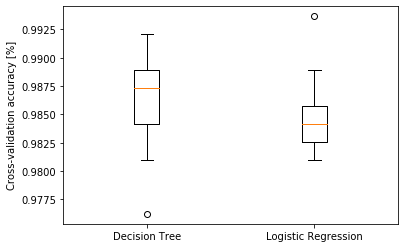

In [75]:
dat=[ACU_tree,ACU_reg]
plt.boxplot(dat,labels=["Decision Tree","Logistic Regression"])
plt.ylabel('Cross-validation accuracy [%]');


In [76]:
from scipy import stats
# Use T-test to check if classifiers are significantly different
[tstatistic, pvalue] = stats.ttest_ind(ACU_reg,ACU_tree)
if pvalue<=0.05:
    print('Classifiers are significantly different. (p={0})'.format(pvalue))
else:
    print('Classifiers are not significantly different (p={0})'.format(pvalue))        

Classifiers are not significantly different (p=0.6779658941065945)
